In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **資料預處理**

In [ ]:
from zipfile import ZipFile
path = "/content/drive/MyDrive/ttgroup/0_9000/0519_out_resize256x256_0_9000_skeleton.zip"
f = ZipFile(path)
# f.extractall() 小括號是直接解壓縮在同一層
f.extractall()

In [ ]:
# 製作igm_name的list
import glob
import pandas as pd
import numpy as np

# sorted() : 排序所有可跌代對象
# split() : 分割()
fn_dic = {"img_name":[]}
paths = sorted(glob.glob("0519_out_resize256x256_0_9000_skeleton/*"))
for path in paths:
  fn = path.split("/")[-1].split(".")[0]
  fn_dic["img_name"].append(fn)
fn_dic_df = pd.DataFrame(fn_dic)
fn_dic_df

,img_name
0,0004
1,0044
2,0070
3,0089
4,0095
...,...
580,8868
581,8872
582,8877
583,8903


In [ ]:
# img_combine_arr 訓練資料DataFarme (x_train, x_test)
from PIL import Image
fn_list = fn_dic["img_name"]

# # RGB寫法
img_arr_list = []
for fn in fn_list:
  img = Image.open("0519_out_resize256x256_0_9000_skeleton/" + fn + ".jpg").convert("RGB")
  img = img.resize((256, 256))
  globals()["img_"+ fn] = img
  globals()["img_"+ fn + "_arr"] = np.array(globals()["img_"+fn])
  img_arr_list.append(globals()["img_"+ fn + "_arr"])
  img.close()
# img_arr_list = ()
img_combine_arr = np.array(img_arr_list)
img_combine_arr.shape
# img_combine_arr[0]

(585, 256, 256, 3)

In [ ]:
# ans_df  驗證資料DataFrame (y_train, y_test)
base = "/content/drive/MyDrive/ttgroup/0_9000/0519_wrong_total_sit_value_combinefoot_0_9000.csv"
csv = pd.read_csv(base, sep=",")
ans_df = pd.DataFrame(csv)
ans_df = ans_df.drop(["img_name"], axis=1)
ans_arr = np.array(ans_df)
ans_df

,head,shoulder,foot
0,1,0,1
1,1,1,1
2,1,1,1
3,1,0,1
4,1,0,1
...,...,...,...
580,1,0,0
581,0,0,1
582,1,0,0
583,0,0,1


In [ ]:
# 切割資料 x_train, x_test, y_train, y_test
from sklearn.model_selection import train_test_split
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(img_combine_arr,
                             ans_arr,
                             test_size=0.1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(526, 256, 256, 3)
(526, 3)
(59, 256, 256, 3)
(59, 3)


80
[1 0 0]


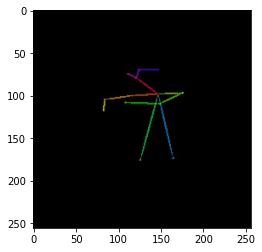

In [ ]:
# 顯示圖片和標籤
import random
import matplotlib.pyplot as plt
idx = random.randint(0, 260)
print(idx)
print(y_train[idx])
plt.imshow(x_train[idx])

# **模型建置**

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
layers = [
    Conv2D(64, 3, padding="same", activation="relu", input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(128, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(256, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(512, 3, padding="same", activation="relu"),
    GlobalAveragePooling2D(),
    Dense(3, activation="sigmoid")
]
model = Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 512)      

In [ ]:
from tensorflow.keras.losses import BinaryCrossentropy
model.compile(loss=BinaryCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

In [ ]:
x_train_norm = x_train / 255
x_test_norm = x_test / 255

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks = [
   EarlyStopping(patience=5, restore_best_weights=True),
   ModelCheckpoint("cnn.h5", save_best_only=True) 
]

model.fit(x_train_norm,
     y_train,
     batch_size=20,
     epochs=50,
     validation_split=0.1,
     verbose=2,
     callbacks=callbacks)

Epoch 1/50
24/24 - 2s - loss: 0.3725 - accuracy: 0.6216 - val_loss: 0.3776 - val_accuracy: 0.6038
Epoch 2/50
24/24 - 2s - loss: 0.3527 - accuracy: 0.6237 - val_loss: 0.4092 - val_accuracy: 0.5283
Epoch 3/50
24/24 - 2s - loss: 0.3443 - accuracy: 0.6364 - val_loss: 0.4048 - val_accuracy: 0.6038
Epoch 4/50
24/24 - 2s - loss: 0.3424 - accuracy: 0.6448 - val_loss: 0.4063 - val_accuracy: 0.5472
Epoch 5/50
24/24 - 2s - loss: 0.3367 - accuracy: 0.6427 - val_loss: 0.4667 - val_accuracy: 0.4340
Epoch 6/50
24/24 - 2s - loss: 0.3354 - accuracy: 0.6300 - val_loss: 0.3775 - val_accuracy: 0.5472
Epoch 7/50
24/24 - 2s - loss: 0.3154 - accuracy: 0.6575 - val_loss: 0.3767 - val_accuracy: 0.6226
Epoch 8/50
24/24 - 2s - loss: 0.3077 - accuracy: 0.6596 - val_loss: 0.4031 - val_accuracy: 0.5849
Epoch 9/50
24/24 - 2s - loss: 0.2935 - accuracy: 0.6681 - val_loss: 0.3695 - val_accuracy: 0.6415
Epoch 10/50
24/24 - 2s - loss: 0.3062 - accuracy: 0.6596 - val_loss: 0.3768 - val_accuracy: 0.6226
Epoch 11/50
24/24 -

In [ ]:
model.evaluate(x_test_norm, y_test)

2/2 [==============================] - 0s 58ms/step - loss: 0.3398 - accuracy: 0.7797


[0.3398074805736542, 0.7796609997749329]

輸入檔名:/content/sho_ft_non.jpg
預測數值 [0.7883076667785645, 0.3458542823791504, 0.992510199546814]
T&F: [1, 0, 1]
correct: ['shoulder']
wrong: ['head', 'foot']


(-0.5, 255.5, 255.5, -0.5)

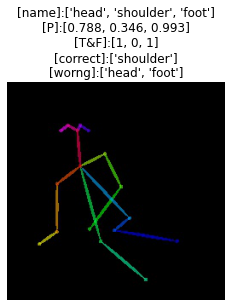

In [ ]:
from PIL import Image
fn = input("輸入檔名:")
img = Image.open(fn).resize((256, 256)).convert("RGB")
img_np = np.array(img)
img_np_r = img_np.reshape(1, 256, 256, 3) / 255.0
pre = model.predict(img_np_r)[0]

pre_list = pre.tolist()
print("預測數值", pre_list)

ans_names = ans_df.columns.tolist()
ans_list = []
for i, ans_name in enumerate(ans_names):
  ans = round(pre_list[i])
  ans_list.append(ans)
print("T&F:", ans_list)

correct = []
wrong = []
for i, ans_val in enumerate(ans_list):
  if ans_val == 1:
    wrong.append(ans_names[i])
  else:
    correct.append(ans_names[i])
print("correct:", correct)
print("wrong:", wrong)
plt.imshow(img_np)
t = "[name]:{}\n[P]:{}\n[T&F]:{}\n[correct]:{}\n[worng]:{}".format(ans_names,
                             [round(f,3) for f in pre_list], 
                             ans_list,
                             correct,
                             wrong)
plt.title(t)
plt.axis("off")